## Лабораторная работа № 8. Оптимизация

### 8.2.1. Линейное программирование
Линейное программирование рассматривает решения экстремальных задач на множествах 𝑛-мерного векторного пространства, задаваемых системами линейных уравнений и неравенств.
Общей (стандартной) задачей линейного программирования называется задача нахождения минимума линейной целевой функции вида:

In [1]:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
using JuMP
using GLPK

    Updating registry at `C:\Users\Meric\.julia\registries\General.toml`
   Resolving package versions...
   Installed CodecBzip2 ─────── v0.8.1
   Installed JuMP ───────────── v1.17.0
   Installed MathOptInterface ─ v1.23.0
    Updating `C:\Users\Meric\.julia\environments\v1.9\Project.toml`
  [4076af6c] + JuMP v1.17.0
    Updating `C:\Users\Meric\.julia\environments\v1.9\Manifest.toml`
  [523fee87] + CodecBzip2 v0.8.1
  [4076af6c] + JuMP v1.17.0
  [b8f27783] + MathOptInterface v1.23.0
Precompiling project...
  ✓ CodecBzip2
  ✓ MathOptInterface
  ✓ JuMP
  3 dependencies successfully precompiled in 144 seconds. 416 already precompiled. 5 skipped during auto due to previous errors.
   Resolving package versions...
   Installed GLPK_jll ─ v5.0.1+0
   Installed GLPK ───── v1.1.3
    Updating `C:\Users\Meric\.julia\environments\v1.9\Project.toml`
  [60bf3e95] + GLPK v1.1.3
    Updating `C:\Users\Meric\.julia\environments\v1.9\Manifest.toml`
  [60bf3e95] + GLPK v1.1.3
  [e8aa6df9] + GLPK_jll

In [3]:
model = Model(GLPK.Optimizer)
@variable(model, x >= 0)
@variable(model, y >= 0)
@constraint(model, 6x + 8y >= 100)
@constraint(model, 7x + 12y >= 120)
@objective(model, Min, 12x + 20y)
optimize!(model)

In [5]:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [6]:
@show value(x);
@show value(y);
@show objective_value(model);

value(x) = 14.999999999999993
value(y) = 1.2500000000000047
objective_value(model) = 205.0


### 8.2.2. Векторизованные ограничения и целевая функция оптимизации

In [9]:
A= [ 1 1 9 5;
3 5 0 8;
2 0 6 13]
b = [7; 3; 5]
c = [1; 3; 5; 2]
vector_model = Model(GLPK.Optimizer)
@variable(vector_model, x[1:4] >= 0)
@constraint(vector_model, A * x .== b)
@objective(vector_model, Min, c' * x)
optimize!(vector_model)
termination_status(vector_model)
@show objective_value(vector_model);

objective_value(vector_model) = 4.9230769230769225


### 8.2.3. Оптимизация рациона питания

In [10]:
category_data = JuMP.Containers.DenseAxisArray(
[1800 2200;
91 Inf;
0 65;
0 1779],
["calories", "protein", "fat", "sodium"],
["min", "max"])
foods = ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza","salad", "milk", "ice cream"]
cost = JuMP.Containers.DenseAxisArray(
[2.49, 2.89, 1.50, 1.89, 2.09, 1.99, 2.49, 0.89, 1.59], foods)
food_data = JuMP.Containers.DenseAxisArray(
[410 24 26 730;
420 32 10 1190;
560 20 32 1800;
380 4 19 270;
320 12 10 930;
320 15 12 820;
320 31 12 1230;
100 8 2.5 125;
330 8 10 180],
foods,
["calories", "protein", "fat", "sodium"])
model = Model(GLPK.Optimizer)
categories = ["calories", "protein", "fat", "sodium"]
@variables(model, begin
    category_data[c, "min"] <= nutrition[c = categories] <= category_data[c, "max"]
    buy[foods] >= 0
end)
@objective(model, Min, sum(cost[f] * buy[f] for f in foods))
@constraint(model, [c in categories], sum(food_data[f, c] * buy[f] for f in foods) == nutrition[c])
JuMP.optimize!(model)
term_status = JuMP.termination_status(model)
hcat(buy.data,JuMP.value.(buy.data))

9×2 Matrix{AffExpr}:
 buy[hamburger]  0.6045138888888888
 buy[chicken]    0
 buy[hot dog]    0
 buy[fries]      0
 buy[macaroni]   0
 buy[pizza]      0
 buy[salad]      0
 buy[milk]       6.9701388888888935
 buy[ice cream]  2.591319444444441

### 8.2.4. Путешествие по миру

In [13]:
using DelimitedFiles
using CSV

In [15]:
passportdata = readdlm("passport-index-matrix.csv",',')
cntr = passportdata[2:end,1]
vf = (x -> typeof(x)==Int64 || x == "VF" || x == "VOA" ? 1 : 0).(passportdata[2:end,2:end]);
model = Model(GLPK.Optimizer)
@variable(model, pass[1:length(cntr)], Bin)
@constraint(model, [j=1:length(cntr)], sum( vf[i,j]*pass[i] for i in 1:length(cntr)) >= 1)
@objective(model, Min, sum(pass))
JuMP.optimize!(model)
termination_status(model)
print(JuMP.objective_value(model)," passports: ",join(cntr[findall(JuMP.value.(pass) .== 1)],", "))

63.0 passports: Afghanistan, Andorra, Argentina, Australia, Azerbaijan, Bahrain, Brunei, Cambodia, Cameroon, Canada, Chile, Colombia, Comoros, DR Congo, Djibouti, Equatorial Guinea, Eritrea, Fiji, Gabon, Georgia, Guinea, Guinea-Bissau, Hong Kong, Hungary, Indonesia, Iraq, Ireland, Israel, Jamaica, Japan, Kuwait, Laos, Liberia, Libya, Macao, Madagascar, Malaysia, Maldives, Marshall Islands, Mauritania, Mauritius, Mongolia, Mozambique, Nauru, Nepal, New Zealand, North Korea, Palestine, Papua New Guinea, Qatar, Saudi Arabia, Solomon Islands, Somalia, South Sudan, Sri Lanka, Syria, Taiwan, Timor-Leste, Togo, Turkmenistan, United States, Uruguay, Vietnam

### 8.2.5. Портфельные инвестиции

In [1]:
using DataFrames
using XLSX
using Plots
pyplot()
using Convex
using SCS
using Statistics

In [2]:
T = DataFrame(XLSX.readtable("stock_prices.xlsx","Sheet2"))

Row,MSFT,FB,AAPL
,Any,Any,Any
1,101.93,137.95,148.26
2,102.8,143.8,152.29
3,107.71,150.04,156.82
4,107.17,149.01,157.76
5,102.78,165.71,166.52
6,105.67,167.33,170.41
7,108.22,162.5,170.42
8,110.97,161.89,172.97
9,112.53,162.28,174.97


In [8]:
prices_matrix = Matrix(T)
M1 = prices_matrix[1:end-1,:]
M2 = prices_matrix[2:end,:]
R = (M2.-M1)./M1
risk_matrix = cov(R)
isposdef(risk_matrix)
r = mean(R,dims=1)[:]
x = Variable(length(r))
problem = minimize(Convex.quadform(x,risk_matrix),[sum(x)==1;r'*x>=0.02;x.>=0])
solve!(problem, SCS.Optimizer)
sum(x.value)

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 6, constraints m: 14
cones: 	  z: primal zero / dual free vars: 2
	  l: linear vars: 5
	  q: soc vars: 7, qsize: 2
settings: eps_abs: 1.0e-004, eps_rel: 1.0e-004, eps_infeas: 1.0e-007
	  alpha: 1.50, scale: 1.00e-001, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-006
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 24, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0|1.71e+001 1.00e+000 1.62e+001 -8.03e+000 1.00e-001 8.05e-005 
    75|8.16e-005 1.46e-004 5.60e-005 5.56e-004 1.00e-001 1.30e-004 
------

0.9999994443731297

### 8.2.6. Восстановление изображения

In [13]:
using Images
using Convex
using SCS

[ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
[ Info: Precompiling ForwardDiffStaticArraysExt [b74fd6d0-9da7-541f-a07d-1b6af30a262f]
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
┌ Warning: Module Plots with build ID fafbfcfd-06cc-4e96-0000-1103c2fdb4e5 is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
[ Info: Skipping precompilation since __precompile__(false). Importing FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c].
[ Info: Precompiling SpecialFunctionsChainRulesCoreExt [9eb7bdd4-e44c-55fc-b9cc-1a32cb715188]
[ Info: Precompiling SpecialFunctionsExt [499d2952-c3ce-5339-96ee-b197ee6daaa6]
[ Info: Precompiling ForwardDiffExt [4b8ca102-9d0f-5df8-84ed-253e0f005ba7]


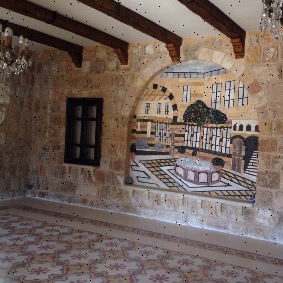

In [16]:
Kref = load("khiam-small.jpg")
K = copy(Kref)
p = prod(size(K))
missingids = rand(1:p,400)
K[missingids] .= RGBX{N0f8}(0.0,0.0,0.0)
K

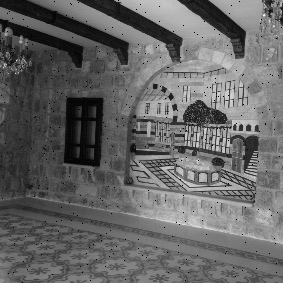

In [17]:
Gray.(K)

### **8.4.1. Линейное программирование**

In [23]:
using GLPK
using JuMP
model = Model(GLPK.Optimizer)
@variable(model, 0 <= x1 <= 10)
@variable(model, x2 >= 0)
@variable(model, x3 >= 0)
@constraint(model, -x1 + x2 + 3x3 <= -5)
@constraint(model, x1 + 3x2 - 7x3 <= 10)
@objective(model, Max, x1 + 2x2 + 5x3)
optimize!(model)
termination_status(model)
@show value(x1);
@show value(x2);
@show value(x3);
@show objective_value(model);

value(x1) = 10.0
value(x2) = 2.1875
value(x3) = 0.9375
objective_value(model) = 19.0625


### **8.4.2. Линейное программирование. Использование массивов**

In [32]:
vector_model = Model(GLPK.Optimizer)
A = [-1 1 3
1 3 -7]
b = [-5 10]
c = [1; 2; 5]
@variable(vector_model, x[1:3] >= 0)
set_upper_bound(x[1], 10)
@constraint(vector_model, A * x .== b)
@objective(vector_model, Min, c' * x)
optimize!(vector_model)
termination_status(vector_model)
@show value(x[1]);
@show value(x[2]);
@show value(x[3]);
@show objective_value(vector_model);

value(x[1]) = 0.0
value(x[2]) = 6.25
value(x[3]) = 1.25
objective_value(vector_model) = 18.75


### **8.4.3. Выпуклое программирование**

In [33]:
using Convex
using SCS
m = 4
n = 3
A = rand(m, n)
b = rand(m)
display(A);
display(b);

4×3 Matrix{Float64}:
 0.466471  0.0389638  0.875438
 0.810185  0.19592    0.980345
 0.896183  0.573366   0.422895
 0.849447  0.500852   0.745057

4-element Vector{Float64}:
 0.29553553478076167
 0.38187300179852746
 0.6208072451470132
 0.9235747852187898

In [37]:
x = Variable(n)
model2 = minimize(Convex.sumsquares(A*x - b), [x >= 0])
solve!(model2, SCS.Optimizer);
model2.status;
model2.optval;

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 6, constraints m: 13
cones: 	  z: primal zero / dual free vars: 1
	  l: linear vars: 4
	  q: soc vars: 8, qsize: 2
settings: eps_abs: 1.0e-004, eps_rel: 1.0e-004, eps_infeas: 1.0e-007
	  alpha: 1.50, scale: 1.00e-001, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-006
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 21, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0|1.71e+001 1.00e+000 1.62e+001 -8.04e+000 1.00e-001 8.55e-005 
   125|1.91e-005 1.01e-005 1.98e-005 5.47e-002 5.92e-001 1.63e-004 
------

### **8.4.5. План приготовления кофе**

In [55]:
using JuMP
using GLPK
coffee_type = ["raf", "cappucino"]
balance_data = JuMP.Containers.DenseAxisArray(
   [
        40 140 5;
        30 120 0
   ],
    coffee_type,
    ["grains", "milk", "vanilin"]
)
coffee_data = JuMP.Containers.DenseAxisArray(
   [
        0 500;
        0 2000;
        0 40;
   ],
    ["grains", "milk", "vanilin"],
    ["min", "max"]
)
coffee_price = JuMP.Containers.DenseAxisArray(
    [400, 300],
    coffee_type
)
coctav = ["grains", "milk", "vanilin"]
model3 = Model(GLPK.Optimizer)
@variables(model3, 
    begin coffee_data[i, "min"] <= nutrition[i = coctav] <= coffee_data[i, "max"]
        use[coffee_type] >= 0
    end)
@objective(model3, Max, sum(coffee_price[c] * use[c] for c in coffee_type))
@constraint(model3, [i in coctav],
    sum(balance_data[c, i] * use[c] for c in coffee_type) == nutrition[i])

JuMP.optimize!(model3)
term_status = JuMP.termination_status(model3)
hcat(use.data,JuMP.value.(use.data))

2×2 Matrix{AffExpr}:
 use[raf]        8
 use[cappucino]  6